In [7]:
import mne
import argparse
from joblib import Parallel, delayed
import os
import logging
import numpy as np
HOMEDIR = "/Brain/private/v20subra/LSD_project"
def create_source_space(subjects_dir, subject, drug):
    """Create the source space."""
    
    subjects_dir = f"{subjects_dir}/anat/{drug}"
    

    print(f"Creating source space for subject {subject}...")
    src = mne.setup_source_space(subject, spacing='ico5', subjects_dir=subjects_dir, n_jobs=-1)
    return src

def bem(subjects_dir, subject, drug):
    """Create or load the BEM solution."""
    bem_file = f"{subjects_dir}/anat/{drug}/{subject}/bem/{subject}-bem-sol.fif"
    subjects_dir = f"{subjects_dir}/anat/{drug}"
    

    model = mne.make_bem_model(subject=subject, ico=5, conductivity=(0.3,), subjects_dir=subjects_dir)
    bem_sol = mne.make_bem_solution(model)
        
    return bem_sol

def forward_model(subjects_dir, subject, epochs, trans, src, bem_sol, drug):
    """Create or load the forward model."""
    subjects_dir = f"{subjects_dir}/anat/{drug}"


    fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src, bem=bem_sol,
                                    meg=True, eeg=False,mindist=5.0)
    return fwd

def parcellation(stc):
    """Parcellate the source estimate."""
    labels=mne.read_labels_from_annot('fsaverage', 'HCPMMP1', sort=False, subjects_dir='/Brain/private/v20subra/LSD_project/src_data/derivatives/anat/LSD')
    src = mne.read_source_spaces(f"{subjects_dir}/anat/LSD/fsaverage/bem/fsaverage-ico-5-src.fif")

    exclude_indices = [0, 181]
    valid_labels = [label for i, label in enumerate(labels) if i not in exclude_indices]
    
    label_ts = mne.extract_label_time_course(
        stc, labels=valid_labels, src=src, mode="mean", allow_empty=True, mri_resolution=False
    )
    return label_ts



In [8]:
subject = "003"
drug = "LSD"
task = "Music"
subjects_dir = '/Brain/private/v20subra/LSD_project/src_data/derivatives/'

subject = f"sub-{subject}"
trans_file = f"{subjects_dir}/anat/{drug}/{subject}/bem/{subject}_trans.fif"
trans = mne.read_trans(trans_file)

In [ ]:
#### A) Same script without empty room recordings
"""
.. _tut-inverse-methods:

========================================================
Source localization with MNE, dSPM, sLORETA, and eLORETA
========================================================

The aim of this tutorial is to teach you how to compute and apply a linear
minimum-norm inverse method on evoked/raw/epochs data.
"""

# Authors: The MNE-Python contributors.
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

# %%

import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator

# %%
# Process MEG data

data_path = sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel="STI 014")

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info["bads"] = ["MEG 2443", "EEG 053"]  # mark known bad channels
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("meg", "eog"),
    baseline=baseline,
    reject=reject,
)

# %%
# Compute regularized noise covariance
# ------------------------------------
# For more details see :ref:`tut-compute-covariance`.

noise_cov_data = np.eye(epochs.info['nchan']) 
noise_cov = mne.Covariance(data=noise_cov_data, names=epochs.info['ch_names'], bads=[], projs=[], nfree=1)


# %%
# Compute the evoked response
# ---------------------------
# Let's just use the MEG channels for simplicity.

evoked = epochs.average().pick("meg")
evoked.plot(time_unit="s")
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type="mag")

# %%
# It's also a good idea to look at whitened data:

evoked.plot_white(noise_cov, time_unit="s")
del epochs, raw  # to save memory

# %%
# Inverse modeling: MNE/dSPM on evoked and raw data
# -------------------------------------------------
# Here we first read the forward solution. You will likely need to compute
# one for your own data -- see :ref:`tut-forward` for information on how
# to do it.

fname_fwd = data_path / "MEG" / "sample" / "sample_audvis-meg-oct-6-fwd.fif"
fwd = mne.read_forward_solution(fname_fwd)

# %%
# Next, we make an MEG inverse operator.

inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, loose=0.2, depth=0.8
)
del fwd

# %%
# .. note::
#
#     You can write the inverse operator to disk with:
#
#     .. code-block::
#
#         from mne.minimum_norm import write_inverse_operator
#         write_inverse_operator(
#             "sample_audvis-meg-oct-6-inv.fif", inverse_operator
#         )
#
# Compute inverse solution
# ------------------------
# We can use this to compute the inverse solution and obtain source time
# courses:

method = "dSPM"  # could choose MNE, sLORETA, or eLORETA instead
snr = 3.0
lambda2 = 1.0 / snr**2
stc, residual = apply_inverse(
    evoked,
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,
    return_residual=True,
    verbose=True,
)

# %%
# Visualization
# -------------
# We can look at different dipole activations:

fig, ax = plt.subplots()
ax.plot(1e3 * stc.times, stc.data[::100, :].T)
ax.set(xlabel="time (ms)", ylabel=f"{method} value")

# %%
# Examine the original data and the residual after fitting:

fig, axes = plt.subplots(2, 1)
evoked.plot(axes=axes)
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color("#98df81")
residual.plot(axes=axes)

# %%
# Here we use peak getter to move visualization to the time point of the peak
# and draw a marker at the maximum peak vertex.

# sphinx_gallery_thumbnail_number = 9



In [9]:
## C) Sample MEG to Subject's mesh
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator

# # %%
# Process MEG data

data_path = sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel="STI 014")

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info["bads"] = ["MEG 2443", "EEG 053"]  # mark known bad channels
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("meg", "eog"),
    baseline=baseline,
    reject=reject,
)

# # Create the source space
src = create_source_space(subjects_dir, subject, drug)

# Create or load the BEM solution
bem_sol = bem(subjects_dir, subject, drug)

trans = '/Brain/private/v20subra/LSD_project/src_data/derivatives/anat/PLA/sub-003_sample_subject/bem/sub-003_trans.fif'

# # # Create or load the forward model
fwd_model = forward_model(subjects_dir, subject, epochs, trans, src, bem_sol, drug)

#Compute the noise covariance matrix
noise_cov_data = np.eye(epochs.info['nchan']) 
noise_cov = mne.Covariance(data=noise_cov_data, names=epochs.info['ch_names'], bads=[], projs=[], nfree=1)

# Create the inverse operator
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd_model, noise_cov, loose=0.2, depth=0.8)
print(f"Inverse operator created for subject {subject}.")

# # # Apply the inverse solution to create a source estimate
method = "dSPM"  # could choose MNE, sLORETA, or eLORETA instead
snr = 3.0 # or 1 
lambda2 = 1.0 / snr**2
evoked = epochs.average()
# stcs = mne.minimum_norm.apply_inverse(evoked, inverse_operator, lambda2,
#                                           method=method)`
stc, residual = mne.minimum_norm.apply_inverse(
    evoked,
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,
    return_residual=True,
    verbose=True,
)



Opening raw data file /homes/v20subra/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Creating source space for subject sub-003...
Setting up the source space with the following parameters:

SUBJECTS_DIR = /Brain/private/v20subra/LSD_project/src_data/derivatives/anat/LSD
Subject      = sub-003
Surface      = white
Icosahedron subdivision grade 5



>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /Brain/private/v20subra/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/lh.white...
Mapping lh sub-003 -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Brain/private/v20subra/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 10242/140321 selected to source space (ico = 5)

Loading /Brain/private/v20subra/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/rh.white...
Mapping rh sub-003 -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Brain/private/v20subra/LSD_project/src_data/derivatives/anat/LSD/sub-003/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 10242/138252 selected to source space (ico = 5)

Calculating source space distances (limit=inf mm)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  48 | elapsed:   30.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  21 out of  48 | elapsed:   32.1s remaining:   41.3s
[Parallel(n_jobs=-1)]: Done  31 out of  48 | elapsed:   32.9s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  41 out of  48 | elapsed:   34.0s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   35.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  48 | elapsed:   26.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  21 out of  48 | elapsed:   28.1s remaining:   36.1s
[Parallel(n_jobs=-1)]: Done  31 out of  48 | elapsed:   30.3s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  41 out of  48 | elapsed:   30.9s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   31.9s finished


    Computing patch statistics...
    Patch information added...
    Computing patch statistics...
    Patch information added...
You are now one step closer to computing the gain matrix
Creating the BEM geometry...
Going from 5th to 5th subdivision of an icosahedron (n_tri: 20480 -> 20480)
inner skull CM is  -4.02 -15.17  -6.10 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (10242) -> inner skull (10242) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.
Source space          : <SourceSpaces: [<surface (lh), n_vertices=140321, n_used=10242>, <surface (rh), n_vertices=138252, n_used=10242>] MRI (surface RAS) coords, subject 'sub-003', ~31.8 MB>
MRI -> head transform : /Brain/private/v20subra/LSD_project/src_data/derivatives/anat/PLA/sub-003_sample_subject/bem/sub-003_trans.fif
Measurement data      : instanc

In [14]:
def morph_subject_activity_to_fsaverage(stcs, fwd, subject_from, subjects_dir, task, drug):
    """Morph the source estimate to fsaverage."""
    
    subjects_dir_anat = f"{subjects_dir}/anat/{drug}"
    
    src_to = mne.read_source_spaces(f"{subjects_dir_anat}/fsaverage/bem/fsaverage-ico-5-src.fif")    
    fsave_vertices = [s["vertno"] for s in src_to]
    
    morph = mne.compute_source_morph(fwd['src'], subject_to='fsaverage', src_to = src_to, spacing=fsave_vertices,
                                    
                                        subjects_dir= subjects_dir_anat)

    stc_morphed = morph.apply(stc)
    
    return stc_morphed


stc_morphed=morph_subject_activity_to_fsaverage(stc, fwd_model, subject, subjects_dir, task, drug)

stc.save('sample_dataset2-stc.h5', ftype='h5')

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    6 smooth iterations done.
    14 smooth iterations done.
[done]
[done]
[done]


In [2]:
subject = "003"
drug = "LSD"
task = "Music"
subjects_dir = '/Brain/private/v20subra/LSD_project/src_data/derivatives/'

subject = f"sub-{subject}"
trans_file = f"{subjects_dir}/anat/{drug}/{subject}/bem/{subject}_trans.fif"
trans = mne.read_trans(trans_file)
# epochs_file = f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_meg.fif"

# epochs = mne.read_epochs(epochs_file, preload=True)
# epochs = epochs.pick_types(meg=True, eeg=False, ref_meg=False)

# if not os.path.exists(f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_resampled_meg.fif"):
#     epochs = epochs.resample(250)
#     epochs.save(f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_resampled_meg.fif", overwrite=True)

# else:
#     epochs = mne.read_epochs(f"{subjects_dir}/func/{task}/{drug}/{subject}/meg/{subject}_cleaned_epochs_resampled_meg.fif", preload=True)
    
# # Create the source space
# src = create_source_space(subjects_dir, subject, drug)

# # Create or load the BEM solution
# bem_sol = bem(subjects_dir, subject, drug)

# # # Create or load the forward model
# fwd_model = forward_model(subjects_dir, subject, epochs, trans, src, bem_sol, drug)

# #Compute the noise covariance matrix
# noise_cov_data = np.eye(epochs.info['nchan']) 
# noise_cov = mne.Covariance(data=noise_cov_data, names=epochs.info['ch_names'], bads=[], projs=[], nfree=1)

# # Create the inverse operator
# inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd_model, noise_cov, loose=0.2, depth=0.8)
# print(f"Inverse operator created for subject {subject}.")

# # # Apply the inverse solution to create a source estimate
# method = "dSPM"  # could choose MNE, sLORETA, or eLORETA instead
# snr = 1.0 # or 1 
# lambda2 = 1.0 / snr**2

# # source_psd = mne.minimum_norm.compute_source_psd_epochs(epochs[:2], inverse_operator, lambda2=lambda2, method=method, fmin=1.0, fmax=60.0, pick_ori=None, label=None, nave=1, pca=True, inv_split=None, adaptive=False, low_bias=True, return_generator=False, n_jobs=None, prepared=False, method_params=None, return_sensor=False, use_cps=True, verbose=None)

In [ ]:
ch_array = [f"ch {i}" for i in range(20484)]

info = mne.create_info(ch_names=ch_array, sfreq=250, ch_types='mag')

source_epochs= mne.EpochsArray(stcs[0].data.reshape(1, stcs[0].data.shape[0], stcs[0].data.shape[1]), info)
source_epochs.compute_psd(fmin=1, fmax=60).plot()

In [18]:
import numpy as np
stc_LSD= np.load('/Brain/private/v20subra/LSD_project/src_data/derivatives/func/Music/LSD/sub-016/meg/source_estimates/sub-016_source_psd.npz')['psd_parcellated']
stc_PLA= np.load('/users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/PLA/sub-016/meg/source_estimates/sub-016_source_psd.npz')['psd_parcellated']

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.average(stc_LSD,axis=0).T)


In [ ]:
plt.plot(np.average(stc_PLA,axis=0).T)


In [19]:
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 15),
    "Beta": (15, 30),
    "Gamma": (30, 49)
}

frequency_resolution = 2  # 2 points per Hz

frequencies = np.arange(len(stc_LSD)) / frequency_resolution


def slice_psd(psd, frequencies, freq_bands):
    sliced_psd = {}
    for band_name, (low, high) in freq_bands.items():
        # Find indices within the frequency range
        indices = np.where((frequencies >= low) & (frequencies <=high))[0]
        # Extract the corresponding PSD values
        sliced_psd[band_name] = psd[:,:,indices]
    return sliced_psd    

In [15]:
# Define subjects and conditions
subjects = ['003', '005', '009', '010', '013', '015', '016',  '018']
conditions = ['LSD', 'PLA']
base_path = '/users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music'

In [33]:
band_power_data = {condition: {band: [] for band in freq_bands} for condition in conditions}


for subj in subjects:
    for condition in conditions:
        
        source_PSD = np.load(f'/users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/{condition}/sub-{subj}/meg/source_estimates/sub-{subj}_source_psd.npz')['psd_parcellated']
        frequency_resolution = 2
        freqs = np.arange(np.shape(source_PSD)[-1]) / frequency_resolution

        
        for band_name, (fmin, fmax) in freq_bands.items():
            
            band_indices = np.where((freqs >= fmin) & (freqs < fmax))[0]
            print(band_name,band_indices)
            # Integrate PSD over the band (sum across frequencies in the band)
            band_power = source_PSD[:, :, band_indices].sum(axis=-1)  # Shape: (n_epochs, n_channels)
            
            # Average across epochs for simplicity
            band_power_avg = band_power.mean(axis=0)  # Shape: (n_channels,)
            
            band_power_data[condition][band_name].append(10*np.log10(band_power_avg))


Delta [2 3 4 5 6 7]
Theta [ 8  9 10 11 12 13 14 15]
Alpha [16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Beta [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Gamma [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 95 96 97]
Delta [2 3 4 5 6 7]
Theta [ 8  9 10 11 12 13 14 15]
Alpha [16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Beta [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Gamma [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 95 96 97]
Delta [2 3 4 5 6 7]
Theta [ 8  9 10 11 12 13 14 15]
Alpha [16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Beta [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Gamma [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 95 96 97]
Delta [2 3 4 5 6 7]
Theta [ 8  

In [34]:
LSD_spectrum = band_power_data['LSD']
PLA_spectrum = band_power_data['PLA']

In [35]:
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection


t, p = stats.ttest_rel(np.array(LSD_spectrum['Alpha']), np.array(PLA_spectrum['Alpha']), axis=0)
fdrcorrection(p)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

(array([143., 110.,  46.,  23.,  13.,   8.,   3.,   6.,   5.,   3.]),
 array([3.96825345e-24, 1.43810619e-23, 2.47938703e-23, 3.52066787e-23,
        4.56194871e-23, 5.60322955e-23, 6.64451039e-23, 7.68579124e-23,
        8.72707208e-23, 9.76835292e-23, 1.08096338e-22]),
 <BarContainer object of 10 artists>)

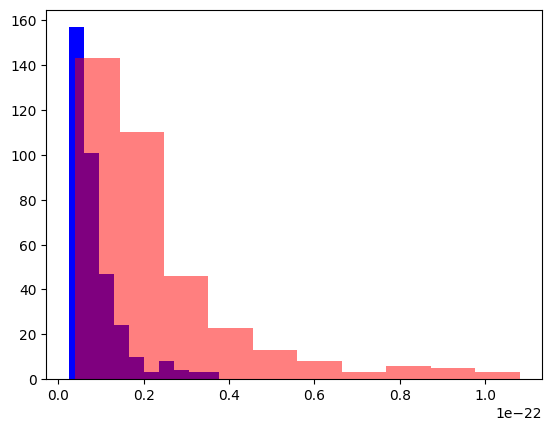

In [151]:
plt.clf()
plt.hist(np.mean(LSD_spectrum['Theta'], axis=0), color='blue')
plt.hist(np.mean(PLA_spectrum['Theta'], axis=0), color='red', alpha=0.5)


In [137]:
np.shape(LSD_spectrum['Beta'])

(8, 360)

In [158]:
source_PSD_bundle = {}

for condition in conditions:
    PSD_subs = []
    for subj in subjects:
        source_PSD = np.load(f'/users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/{condition}/sub-{subj}/meg/source_estimates/sub-{subj}_source_psd.npz')['psd_parcellated']
        PSD_subs.append(np.mean(source_PSD, axis=0))
    
    source_PSD_bundle[f'{condition}'] = PSD_subs
        

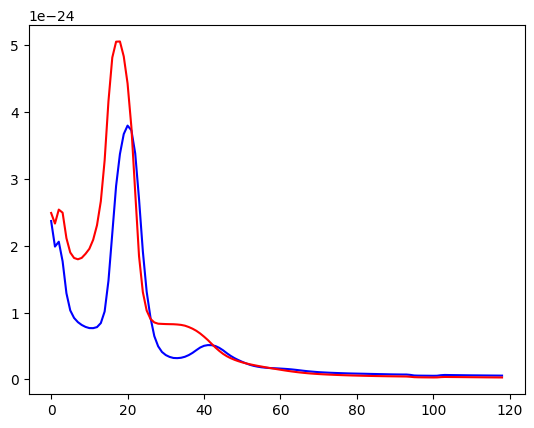

In [168]:
plt.plot(np.array(source_PSD_bundle['LSD']).mean(axis=(0,1)).T, color='b')
plt.plot(np.array(source_PSD_bundle['PLA']).mean(axis=(0, 1)).T, color='red')

# Sensor-level whole Spectrum (i.e time and space-averaged)

In [12]:
# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mne

# Define subjects and conditions
subjects = ['003', '005', '009', '010', '013', '015', '016',  '018']
conditions = ['LSD', 'PLA']
pipeline = "v6"
base_path = f'/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/{pipeline}/Music'




# Define canonical frequency bands
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 50)
}

whole_psd = {}

for condition in conditions:
    psd_data_all_subjects = []
    for subj in subjects:
        file_path = f'{base_path}/{condition}/sub-{subj}/meg/sub-{subj}_cleaned_epochs_meg.fif'
        
        # Read epochs
        epochs = mne.read_epochs(file_path)
        psd = epochs.compute_psd(fmax=61)
        psd_data = np.mean(psd.get_data(), axis=0)
        
        psd_data_all_subjects.append(psd_data)
    
    whole_psd[condition] = np.array(psd_data_all_subjects)



Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-003/meg/sub-003_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-003/meg/sub-003_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
126 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-005/meg/sub-005_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-005/meg/sub-005_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-009/meg/sub-009_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-009/meg/sub-009_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-010/meg/sub-010_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-010/meg/sub-010_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-013/meg/sub-013_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-013/meg/sub-013_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-015/meg/sub-015_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-015/meg/sub-015_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
169 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-016/meg/sub-016_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-016/meg/sub-016_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-018/meg/sub-018_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/LSD/sub-018/meg/sub-018_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-003/meg/sub-003_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-003/meg/sub-003_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-005/meg/sub-005_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-005/meg/sub-005_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-009/meg/sub-009_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-009/meg/sub-009_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-010/meg/sub-010_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-010/meg/sub-010_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-013/meg/sub-013_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-013/meg/sub-013_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-015/meg/sub-015_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-015/meg/sub-015_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-016/meg/sub-016_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-016/meg/sub-016_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-018/meg/sub-018_cleaned_epochs_meg.fif ...


/tmp/ipykernel_1513992/3113824215.py:34: RuntimeWarning: This filename (/Brain/private/v20subra/LSD_project/src_data/derivatives_pipelines/v6/Music/PLA/sub-018/meg/sub-018_cleaned_epochs_meg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path)


    Found the data of interest:
        t =       0.00 ...    1999.17 ms
        0 CTF compensation matrices available
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_1513992/2354046478.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x='Frequency', y='Power', hue='Condition', ci=95)


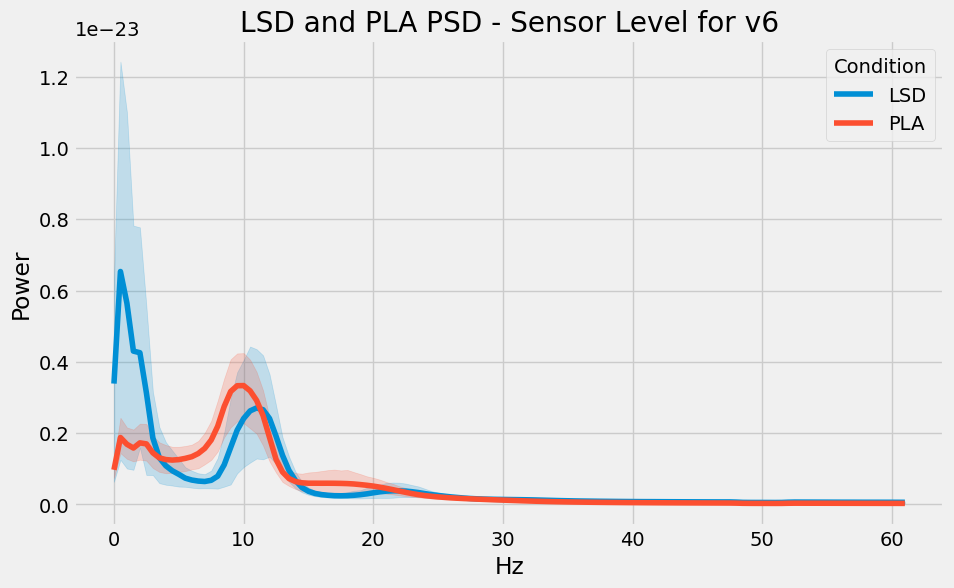

In [13]:

plt.style.use('fivethirtyeight')

def plot_psd(whole_psd_array, where):

    LSD_array_channel_avg = np.mean(whole_psd_array['LSD'], axis=1)  # Shape: (Subjects, Frequencies)
    PLA_array_channel_avg = np.mean(whole_psd_array['PLA'], axis=1)  # Shape: (Subjects, Frequencies)

    # Prepare DataFrame for seaborn
    freqs = np.arange(LSD_array_channel_avg.shape[1])/2  # Frequency bins
    df_LSD = pd.DataFrame(LSD_array_channel_avg, columns=freqs)
    df_LSD = df_LSD.melt(var_name='Frequency', value_name='Power')
    df_LSD['Condition'] = 'LSD'

    df_PLA = pd.DataFrame(PLA_array_channel_avg, columns=freqs)
    df_PLA = df_PLA.melt(var_name='Frequency', value_name='Power')
    df_PLA['Condition'] = 'PLA'

    # Combine the data
    df = pd.concat([df_LSD, df_PLA])
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Frequency', y='Power', hue='Condition', ci=95)
    plt.title(f'LSD and PLA PSD - {where}')
    plt.xlabel('Hz')
    plt.ylabel('Power')
    plt.legend(title='Condition')
    plt.grid(True)
    plt.show()
    
    
plot_psd(whole_psd, f'Sensor Level for {pipeline}')

    

In [50]:
source_PSD_bundle = {}

for condition in conditions:
    PSD_subs = []
    for subj in subjects:
        source_PSD = np.load(f'/users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/{condition}/sub-{subj}/meg/source_estimates/sub-{subj}_source_psd.npz')['psd_parcellated']
        PSD_subs.append(np.mean(source_PSD, axis=0))
    
    source_PSD_bundle[f'{condition}'] = 10*np.log10(PSD_subs)
        

/tmp/ipykernel_3358450/4093487451.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x='Frequency', y='Power', hue='Condition', ci=95)


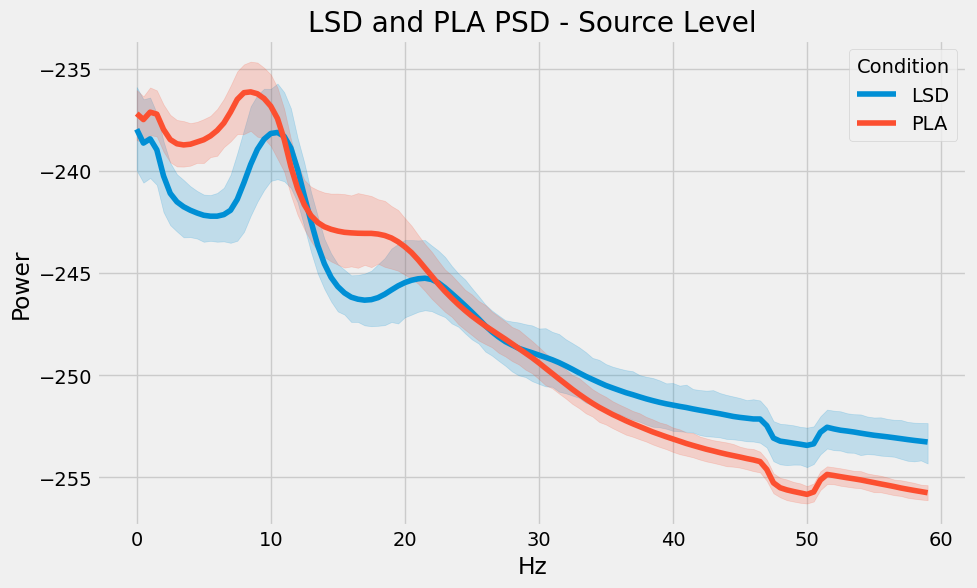

In [47]:
plot_psd(source_PSD_bundle, 'Source Level')

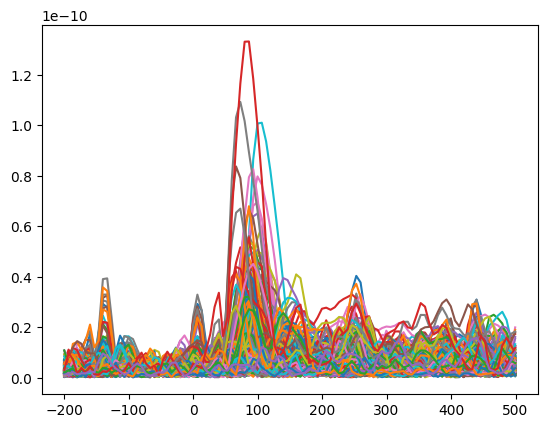

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

plt.plot(1e3 * stc.times, stc.data[::100, :].T)


In [7]:
# vertno_max, time_max = stc.get_peak(hemi="rh")
stc.save('sample_dataset', ftype='h5', overwrite=True)

stc

Overwriting existing file.
[done]


<SourceEstimate | 20484 vertices, subject : sub-005, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 6.659840438612929 (ms), data shape : (20484, 106), ~16.7 MB>

In [2]:
stc = mne.read_source_estimate('sample_dataset-stc.h5', subject='sub-003')
# vertno_max, time_max = stc.get_peak(hemi="rh")

# subjects_dir = "/Brain/private/v20subra/LSD_project/src_data/derivatives/anat/LSD"
# surfer_kwargs = dict(
#     hemi="rh",
#     subjects_dir=subjects_dir,
#     clim=dict(kind="percent", lims=[95, 97 , 100]),
#     spacing="ico5",
#     initial_time=time_max,
#     time_unit="s",
#     size=(1500, 800),
#     smoothing_steps=5,
# )
# brain = stc.plot(**surfer_kwargs, backend='matplotlib')


    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    2 smooth iterations done.
    2 smooth iterations done.
[done]
[done]


In [6]:
stc_morphed.save('sample_dataset_morphed', ftype='h5', overwrite=True)

Overwriting existing file.
[done]


In [2]:
import mne

epoch = mne.io.read_raw('/users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/LSD/sub-015/meg/sub-015_raw_filtered_meg.fif')

Opening raw data file /users/local/Venkatesh/LSD_project/src_data/derivatives/func/Music/LSD/sub-015/meg/sub-015_raw_filtered_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 503999 =      0.000 ...   419.999 secs
Ready.
Current compensation grade : 3


Opening raw data file /homes/v20subra/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting

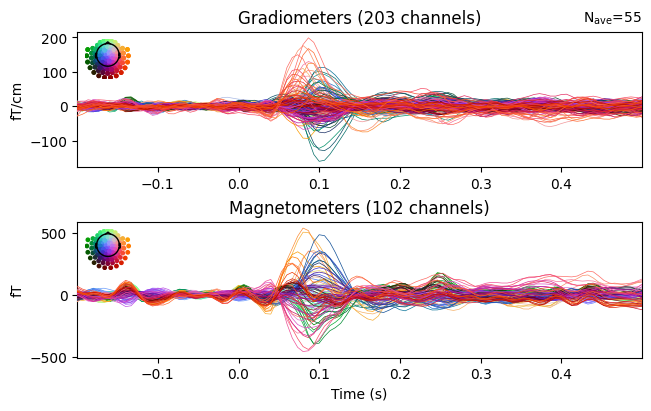

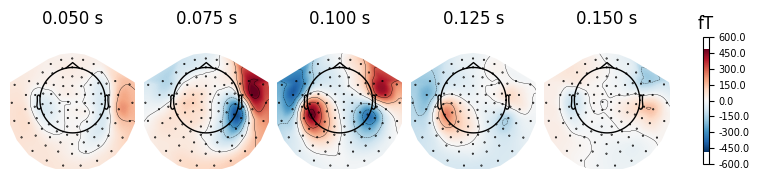

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 4.5e+08 (2.2e-16 eps * 203 dim * 1e+22  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.3e+10 (2.2e-16 eps * 102 dim * 1e+24  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)


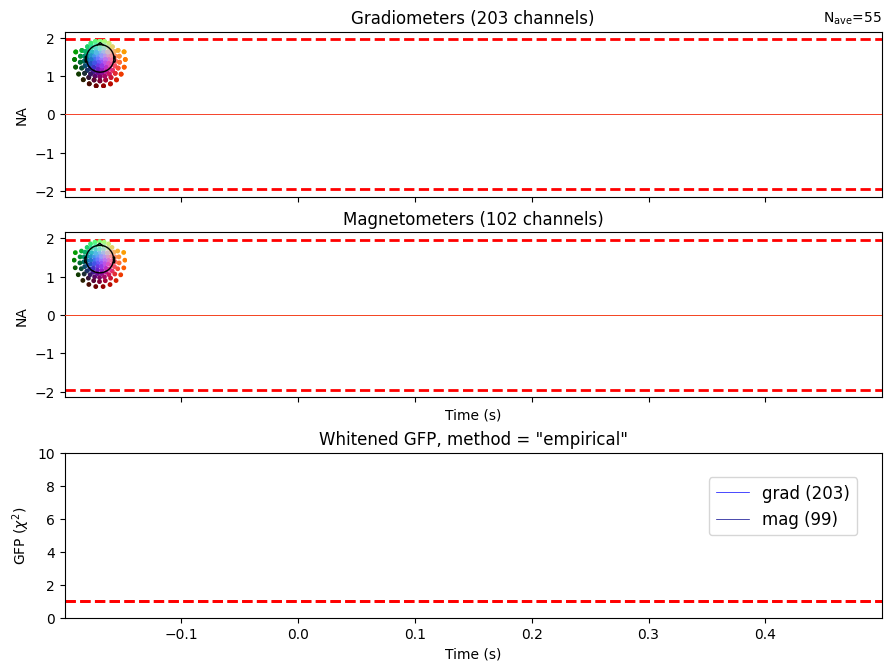

Reading forward solution from /homes/v20subra/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
  

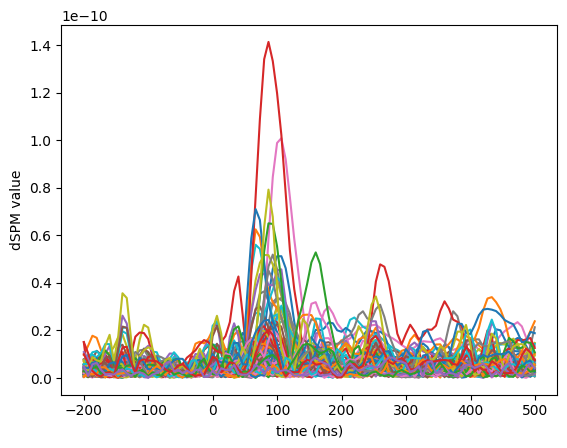

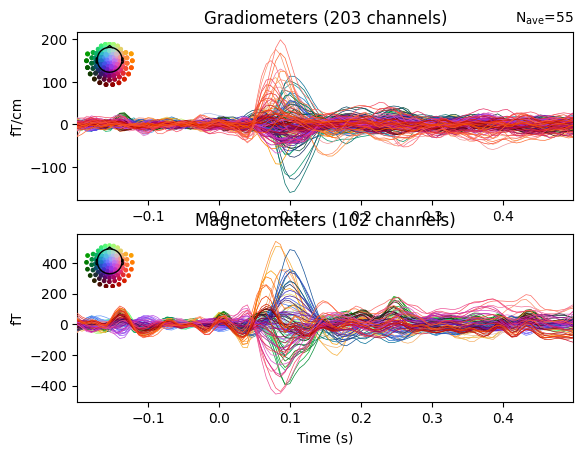

Using pyvistaqt 3d backend.


RuntimeError: Cannot connect to a valid display

In [16]:
stc.save('sample_dataset_fsaverage', ftype='h5', overwrite=True)

[done]
